In [1]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
import pandas as pd
from sklearn import set_config
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline

from sksurv.datasets import load_flchain, load_gbsg2
from sksurv.functions import StepFunction
from sksurv.linear_model import CoxnetSurvivalAnalysis, CoxPHSurvivalAnalysis
from sksurv.ensemble import RandomSurvivalForest, GradientBoostingSurvivalAnalysis
from sksurv.metrics import (
    concordance_index_censored,
    concordance_index_ipcw,
    cumulative_dynamic_auc,
    integrated_brier_score,
)
from sksurv.nonparametric import kaplan_meier_estimator
from sksurv.preprocessing import OneHotEncoder, encode_categorical
from sksurv.util import Surv

import scipy.optimize as opt

set_config(display="text")  # displays text representation of estimators
plt.rcParams["figure.figsize"] = [7.2, 4.8]

In [2]:
def generate_marker(n_samples, m, hazard_ratio, baseline_hazard, rnd):
    # create synthetic risk score
    X = np.array(rnd.randn(n_samples, m))
    w = np.expand_dims(np.array(rnd.uniform(size=m)), axis=0).flatten() # weights

    # create linear model
    logits = np.dot(np.dot(X,w.T), np.log(hazard_ratio))

    # draw actual survival times from exponential distribution,
    # refer to Bender et al. (2005), https://doi.org/10.1002/sim.2059
    u = rnd.uniform(size=n_samples)
    time_event = -np.log(u) / (baseline_hazard * np.exp(logits))

    # compute the actual concordance in the absence of censoring
    Xactual = np.squeeze(np.dot(X, w.T))
    actual = concordance_index_censored(np.ones(n_samples, dtype=bool), time_event, Xactual)
    return X, time_event, actual[0], w # risk scores, time events, actual concordance, weights

In [3]:
def generate_survival_data(n_samples, m, hazard_ratio, baseline_hazard, percentage_cens, rnd):
    X, time_event, actual_c, w = generate_marker(n_samples, m, hazard_ratio, baseline_hazard, rnd)

    def get_observed_time(x): # this censors certain time events
        rnd_cens = np.random.RandomState(0)
        # draw censoring times
        time_censor = rnd_cens.uniform(high=x, size=n_samples)
        event = time_event < time_censor
        time = np.where(event, time_event, time_censor)
        return event, time # returns bool array of if event occured or not/censored, and the time it occured/ was censored

    def censoring_amount(x): # finds optimal time event censoring will be as close to desired censored amount
        event, _ = get_observed_time(x)
        cens = 1.0 - event.sum() / event.shape[0]
        return (cens - percentage_cens) ** 2

    # search for upper limit to obtain the desired censoring amount
    res = opt.minimize_scalar(censoring_amount, method="bounded", bounds=(0, time_event.max()))

    # compute observed time
    event, time = get_observed_time(res.x) # now that we have the optimal time event, we use that to get all the events and times

    # upper time limit such that the probability of being censored is non-zero for `t > tau`
    # we are finding the latest observed event time, and only keeping those events where time is < tau to decrease biases
    tau = time[event].max()
    y = Surv.from_arrays(event=event, time=time)
    mask = time < tau
    X_test = X[mask]
    y_test = y[mask]

    return X_test, y_test, y, actual_c, w # risk scores, event/time with tau applied, event/time without tau, actual c, weights. 

In [4]:
def simulation(n_samples, m, hazard_ratio, n_repeats=100):

    measures = (
        "censoring",
        "Harrel's C",
        "Uno's C",
        "AUC",
        "Brier",
    )
    results = {}

    for model_type in ["rsf", "gbsa", "deepsurv"]:
        data_mean = {}
        data_std = {}
        for measure in measures:
            data_mean[measure] = []
            data_std[measure] = []

        rnd = np.random.RandomState(seed=987)

        # iterate over different amount of censoring
        for cens in (0.1, 0.25, 0.4, 0.5, 0.6, 0.7):
            data = {
                "censoring": [],
                "Harrel's C": [],
                "Uno's C": [],
                "AUC" : [],
                "Brier": [],
            }

            # repeaditly perform simulation
            for _ in range(n_repeats):
                # generate data
                X_test, y_test, y_train, actual_c, w = generate_survival_data(
                    n_samples, m, hazard_ratio, baseline_hazard=0.1, percentage_cens=cens, rnd=rnd
                )

                if model_type == "rsf":
                    model = RandomSurvivalForest(n_estimators=100, min_samples_split=10, min_samples_leaf=15, 
                            max_features="sqrt", n_jobs=-1, random_state=rnd)
                else:
                    model = GradientBoostingSurvivalAnalysis(learning_rate=0.1, n_estimators=100,max_depth=3,random_state=rnd,
                    )
                  
                model.fit(X_test, y_test)

                # predict risk scores (lower predicted survival time = higher risk)
                risk_scores = -model.predict(X_test) # doing neg bec RSF does higher num = better survival time, but harrells c higher num = higher risk or earlier


                # random time points to check auc
                delta = (y_test["time"].max() - y_test["time"].min()) * 1e-6
                times = np.linspace(y_test["time"].min() + delta, y_test["time"].max() - delta, 10)

                # Compute cumulative dynamic AUC
                # this requires that survival times survival_test lie within the range of survival times survival_train
                aucs, _ = cumulative_dynamic_auc(y_train, y_test, risk_scores, times)
                mean_auc = np.nanmean(aucs) # manually get mean to takes out NaNs

                # Breier
                # Estimated probability of remaining event-free at time points specified by times
                pred_func = model.predict_survival_function(X_test) # the predict survival fundtion  
                preds = np.asarray([[fn(t) for t in times] for fn in pred_func]) # the actual points on the function

                brier = integrated_brier_score(y_train, y_test, preds, times)

                # estimate c-index
                c_harrell = concordance_index_censored(y_test["event"], y_test["time"], risk_scores)
                c_uno = concordance_index_ipcw(y_train, y_test, risk_scores)

                
                # save results
                data["censoring"].append(100.0 - y_test["event"].sum() * 100.0 / y_test.shape[0])
                data["Harrel's C"].append(actual_c - c_harrell[0])
                data["Uno's C"].append(actual_c - c_uno[0])
                data["AUC"].append(mean_auc)
                data["Brier"].append(brier)
                
                
            # aggregate results
            for key, values in data.items():
                data_mean[key].append(np.mean(data[key]))
                data_std[key].append(np.std(data[key], ddof=1))

        results[model_type] = {
            "mean": pd.DataFrame.from_dict(data_mean),
            "std": pd.DataFrame.from_dict(data_std),
        }
    return results

In [5]:
def plot_results(data_mean, data_std, model_type=None, **kwargs):
    index = pd.Index(data_mean["censoring"].round(3), name="mean percentage censoring")
    for df in (data_mean, data_std):
        df.drop("censoring", axis=1, inplace=True)
        df.index = index

    fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=True)

    # Concordance indexes plot
    cindex_columns = ["Harrel's C", "Uno's C"]
    data_mean_cindex = data_mean[cindex_columns]
    data_std_cindex = data_std[cindex_columns]
    data_mean_cindex.plot.bar(
        yerr=data_std_cindex,
        ax=axes[0],
        **kwargs
    )
    axes[0].set_ylabel("Actual C - Estimated C")
    title = "Concordance Index Errors"
    if model_type is not None:
        title += f" ({model_type})"
    axes[0].set_title("Concordance Index Errors")
    axes[0].yaxis.grid(True)
    axes[0].axhline(0.0, color="gray")

    # AUC and Brier plot
    auc_brier_columns = ["AUC", "Brier"]
    data_mean_auc_brier = data_mean[auc_brier_columns]
    data_std_auc_brier = data_std[auc_brier_columns]
    data_mean_auc_brier.plot.bar(
        yerr=data_std_auc_brier,
        ax=axes[1],
        **kwargs
    )
    axes[1].set_ylabel("Score")
    title2 = "AUC and Brier Scores"
    if model_type is not None:
        title2 += f" ({model_type})"
    axes[1].set_title(title2)
    axes[1].set_title(title2)
    axes[1].yaxis.grid(True)
    axes[1].set_ylim(0, 1)

    # x-axis label on the bottom plot
    axes[1].set_xlabel("Mean Percentage Censoring")

    plt.tight_layout()
    return fig, axes


In [6]:
ylim = [-0.035, 0.8] 


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sksurv/metrics.py:483: RuntimeWarning: invalid value encountered in divide
  true_pos = cumsum_tp / cumsum_tp[-1]
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sksurv/metrics.py:483: RuntimeWarning: invalid value encountered in divide
  true_pos = cumsum_tp / cumsum_tp[-1]
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sksurv/metrics.py:483: RuntimeWarning: invalid value encountered in divide
  true_pos = cumsum_tp / cumsum_tp[-1]
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sksurv/metrics.py:483: RuntimeWarning: invalid value encountered in divide
  true_pos = cumsum_tp / cumsum_tp[-1]
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sksurv/metrics.py:483: RuntimeWarning: invalid value encountered in divide
  true_pos = cumsum_tp / cumsum_tp[-1]
/Library/Frameworks/Python.fra

(<Figure size 1000x600 with 2 Axes>,
 array([<Axes: title={'center': 'Concordance Index Errors'}, xlabel='mean percentage censoring', ylabel='Actual C - Estimated C'>,
        <Axes: title={'center': 'AUC and Brier Scores'}, xlabel='Mean Percentage Censoring', ylabel='Score'>],
       dtype=object))

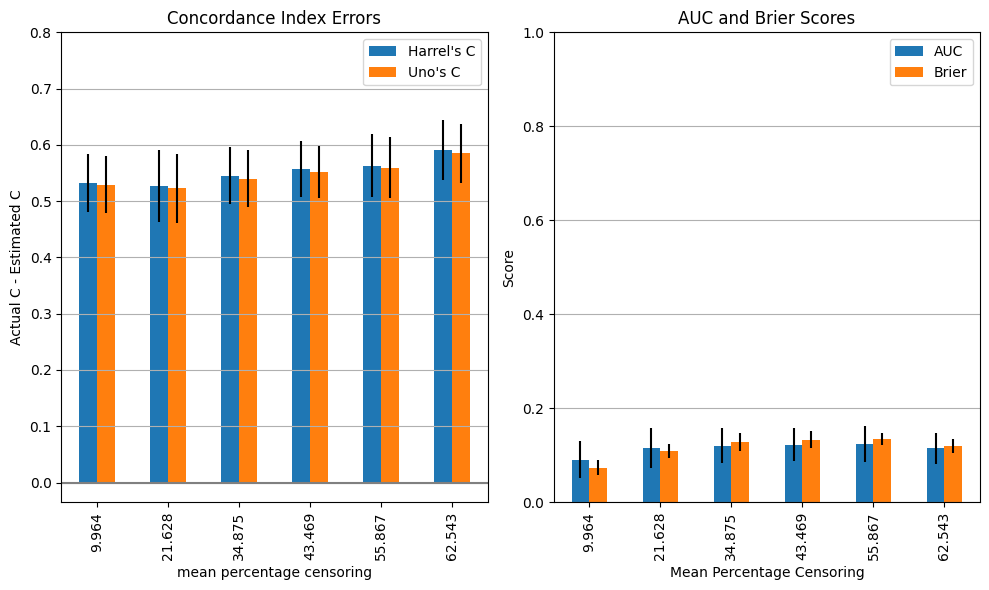

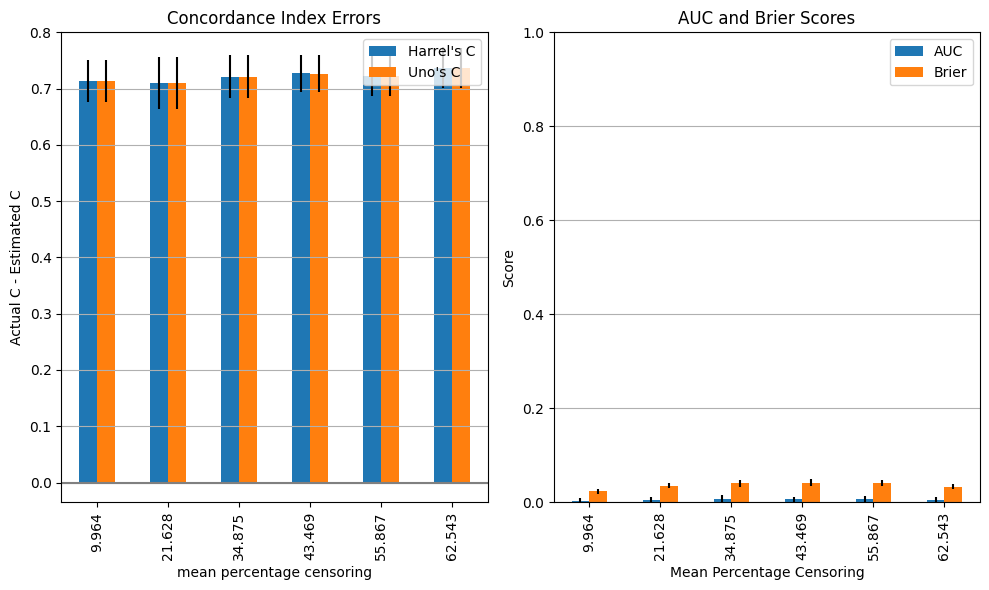

In [7]:
results = simulation(n_samples=100, m=10, hazard_ratio=2.0)

# Access RSF results
rsf_mean = results["rsf"]["mean"]
rsf_std = results["rsf"]["std"]

# Access GBSA results
gbsa_mean = results["gbsa"]["mean"]
gbsa_std = results["gbsa"]["std"]

plot_results(rsf_mean, rsf_std, ylim=ylim, figsize=(10, 6))
plot_results(gbsa_mean, gbsa_std, ylim=ylim, figsize=(10, 6))


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sksurv/metrics.py:483: RuntimeWarning: invalid value encountered in divide
  true_pos = cumsum_tp / cumsum_tp[-1]
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sksurv/metrics.py:483: RuntimeWarning: invalid value encountered in divide
  true_pos = cumsum_tp / cumsum_tp[-1]
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sksurv/metrics.py:483: RuntimeWarning: invalid value encountered in divide
  true_pos = cumsum_tp / cumsum_tp[-1]
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sksurv/metrics.py:483: RuntimeWarning: invalid value encountered in divide
  true_pos = cumsum_tp / cumsum_tp[-1]
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sksurv/metrics.py:483: RuntimeWarning: invalid value encountered in divide
  true_pos = cumsum_tp / cumsum_tp[-1]
/Library/Frameworks/Python.fra

(<Figure size 1000x600 with 2 Axes>,
 array([<Axes: title={'center': 'Concordance Index Errors'}, xlabel='mean percentage censoring', ylabel='Actual C - Estimated C'>,
        <Axes: title={'center': 'AUC and Brier Scores'}, xlabel='Mean Percentage Censoring', ylabel='Score'>],
       dtype=object))

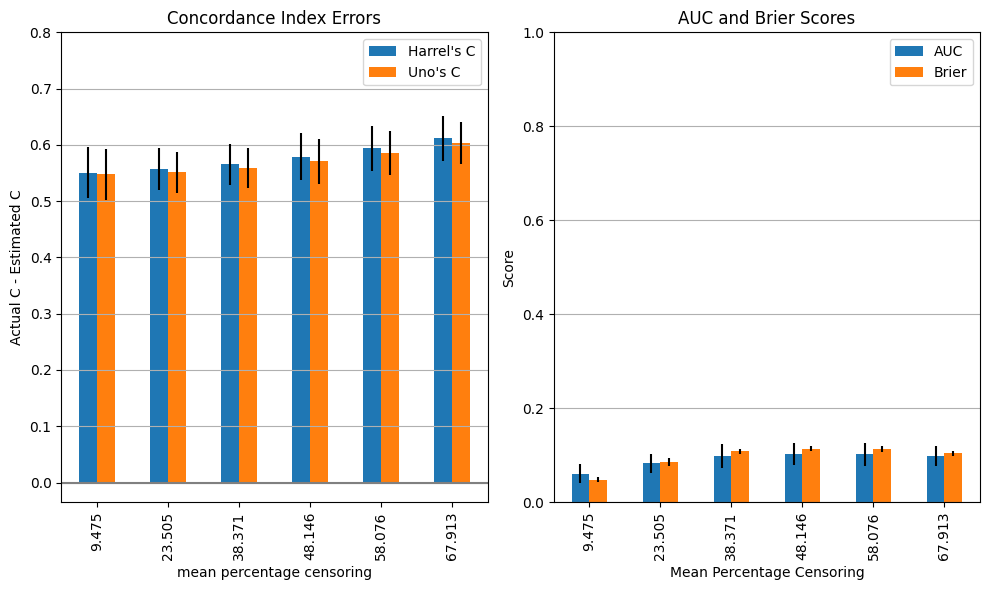

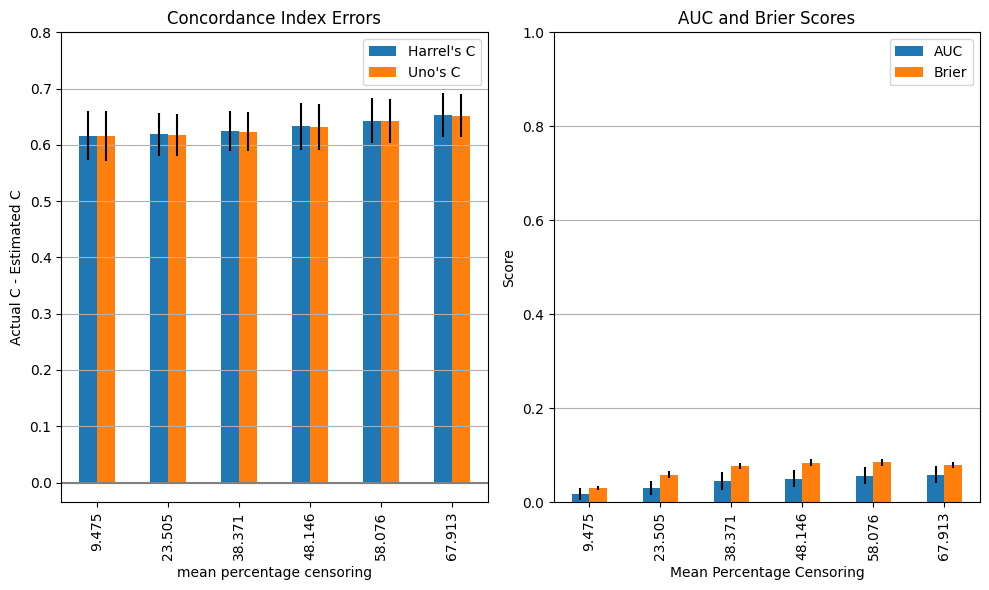

In [8]:
results2 = simulation(n_samples=500, m=10, hazard_ratio=2.0)

# Access RSF results
rsf_mean2 = results2["rsf"]["mean"]
rsf_std2 = results2["rsf"]["std"]

# Access GBSA results
gbsa_mean2 = results2["gbsa"]["mean"]
gbsa_std2 = results2["gbsa"]["std"]

plot_results(rsf_mean2, rsf_std2, ylim=ylim, figsize=(10, 6))
plot_results(gbsa_mean2, gbsa_std2, ylim=ylim, figsize=(10, 6))